In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

In [140]:
#Asked ChatGPT for some companies
nasdaq_shortnames = ["AAPL", "AMZN", "MSFT", "GOOGL", "NFLX", "INTC", "NVDA"]
start_date = datetime(2022, 8, 1)
end_date = datetime(2023, 8, 1)


stock_data = yf.download(nasdaq_shortnames, start_date, end_date)

[*********************100%%**********************]  7 of 7 completed


<Figure size 1000x800 with 0 Axes>

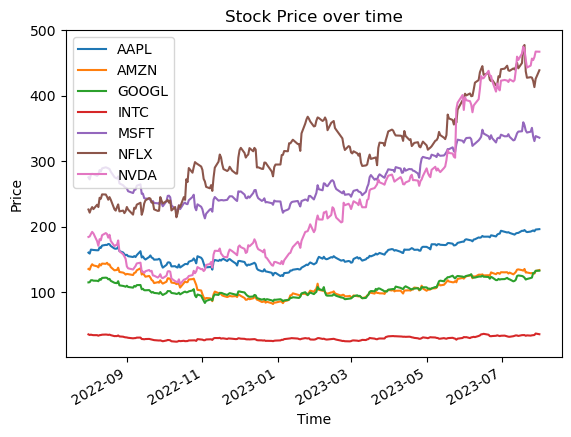

In [141]:
plt.figure(figsize=(10, 8))
stock_data['Adj Close'].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price over time')
plt.savefig('stock_price.png')

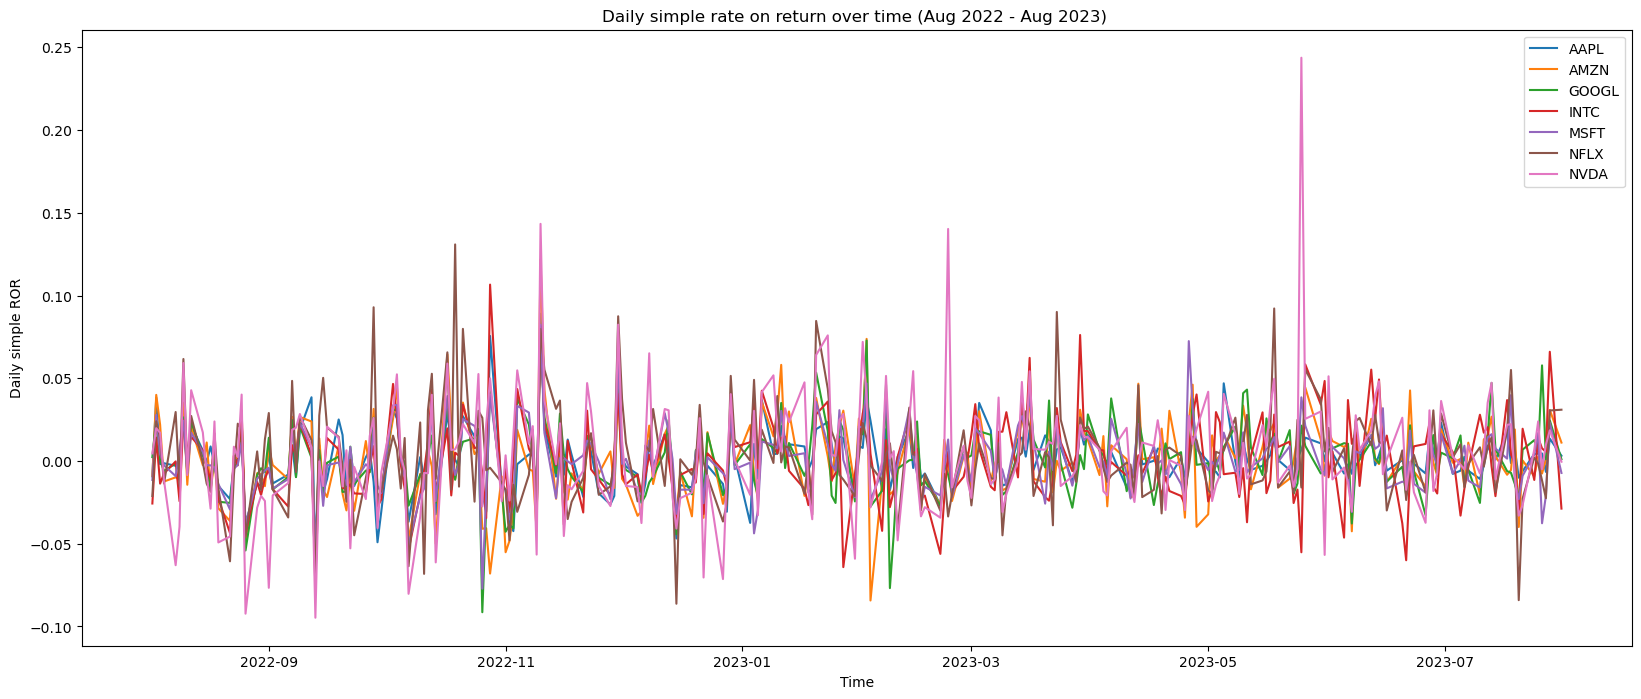

In [142]:
daily_stock_change_pct = stock_data['Adj Close'].pct_change()
plt.figure(figsize=(20,8))
plt.plot(daily_stock_change_pct)
plt.legend(daily_stock_change_pct.columns)
plt.xlabel('Time')
plt.ylabel('Daily simple ROR')
plt.title('Daily simple rate on return over time (Aug 2022 - Aug 2023) ')
plt.savefig('complete_daily_stock_change_1y.png')


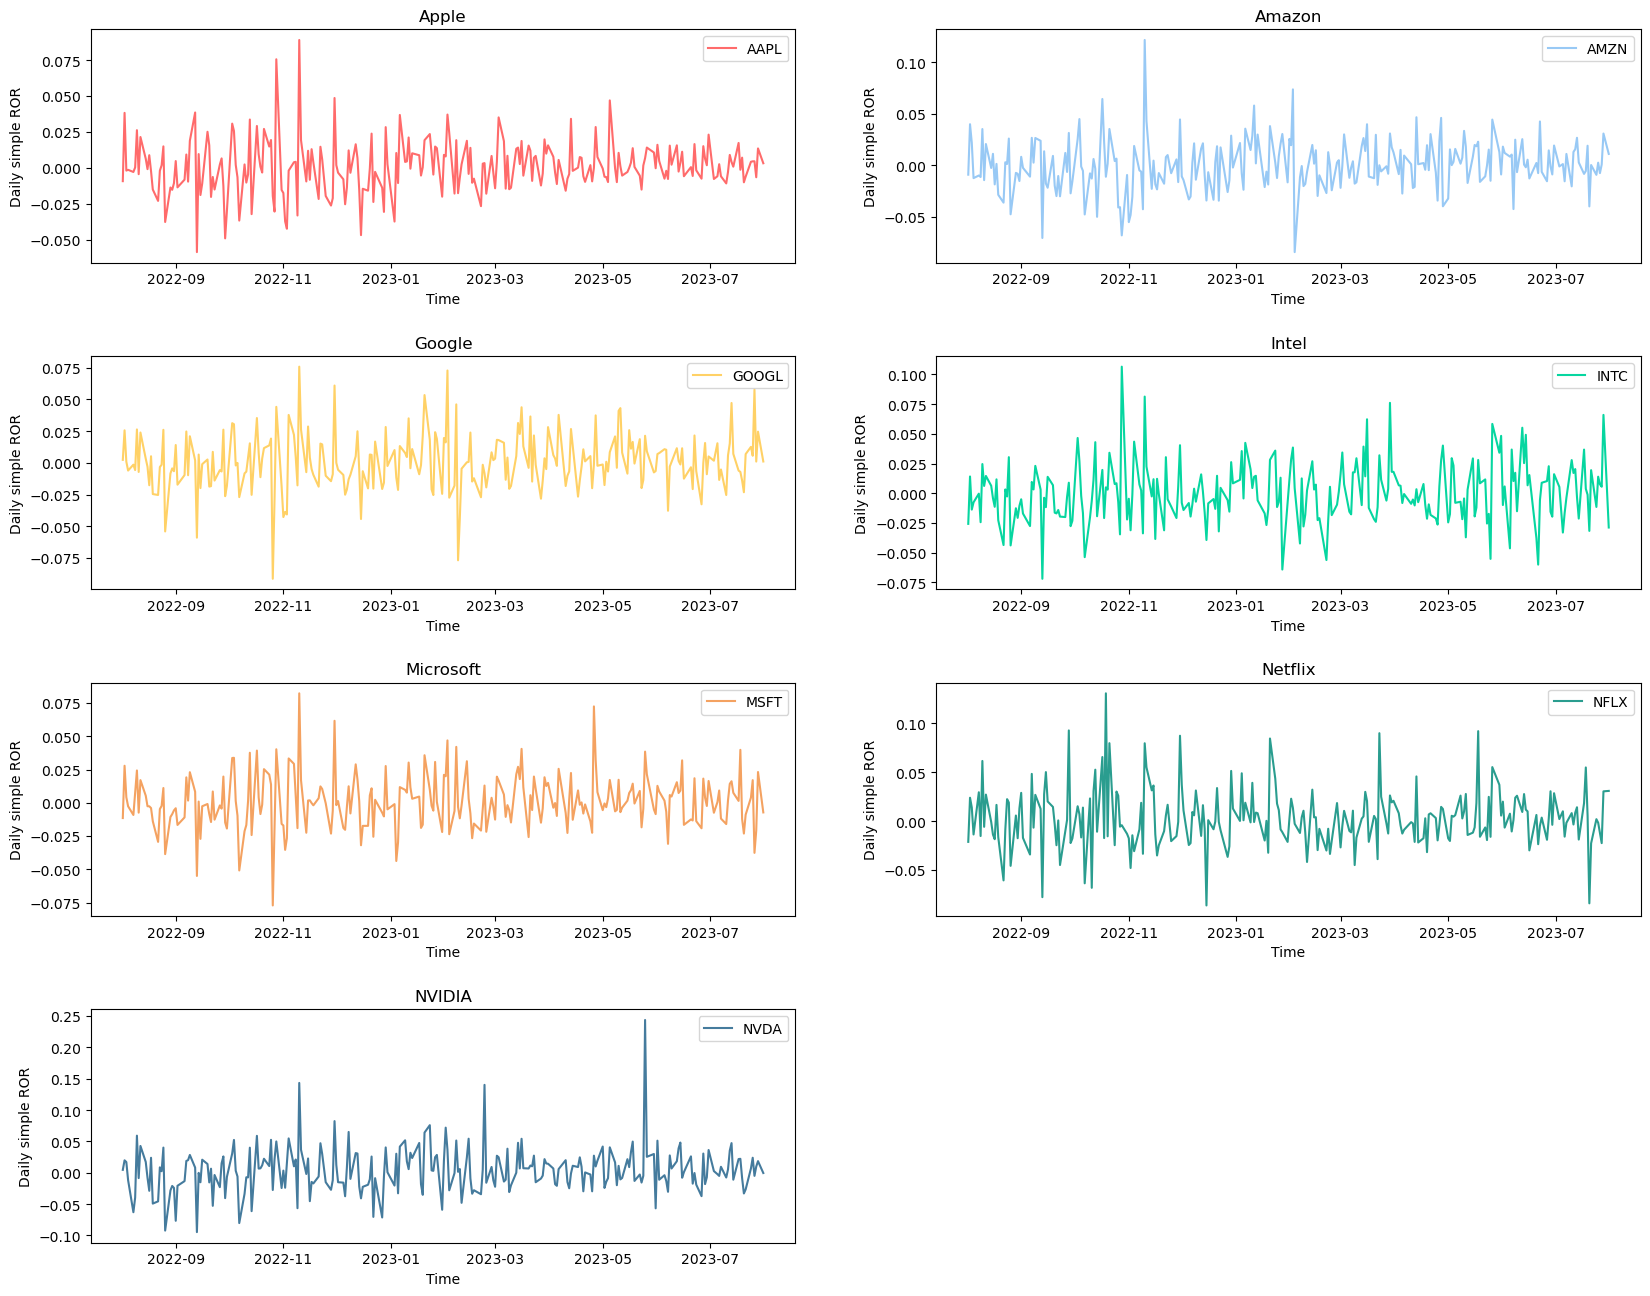

In [143]:
plt.figure(figsize=(20, 20))
plt.subplot(5, 2, 1)
plt.plot(daily_stock_change_pct['AAPL'], color = '#FF6B6B')
plt.legend(['AAPL'])
plt.xlabel('Time')
plt.ylabel('Daily simple ROR')
plt.title('Apple')
plt.subplot(5, 2, 2)
plt.plot(daily_stock_change_pct['AMZN'], color = '#98C9F5')
plt.legend(['AMZN'])
plt.xlabel('Time')
plt.ylabel('Daily simple ROR')
plt.title('Amazon')
plt.subplot(5, 2, 3)
plt.plot(daily_stock_change_pct['GOOGL'], color = '#FFD166')
plt.legend(['GOOGL'])
plt.xlabel('Time')
plt.ylabel('Daily simple ROR')
plt.title('Google')
plt.subplot(5, 2, 4)
plt.plot(daily_stock_change_pct['INTC'], color = '#06D6A0')
plt.legend(['INTC'])
plt.xlabel('Time')
plt.ylabel('Daily simple ROR')
plt.title('Intel')
plt.subplot(5, 2, 5)
plt.plot(daily_stock_change_pct['MSFT'], color = '#F4A261')
plt.legend(['MSFT'])
plt.xlabel('Time')
plt.ylabel('Daily simple ROR')
plt.title('Microsoft')
plt.subplot(5, 2, 6)
plt.plot(daily_stock_change_pct['NFLX'], color = '#2A9D8F')
plt.legend(['NFLX'])
plt.xlabel('Time')
plt.ylabel('Daily simple ROR')
plt.title('Netflix')
plt.subplot(5, 2, 7)
plt.plot(daily_stock_change_pct['NVDA'], color = '#457B9D')
plt.legend(['NVDA'])
plt.xlabel('Time')
plt.ylabel('Daily simple ROR')
plt.title('NVIDIA')


plt.subplots_adjust(hspace=0.4)

plt.savefig('all_stocks_combined.png')

In [144]:
daily_stock_return_mean = daily_stock_change_pct.mean()


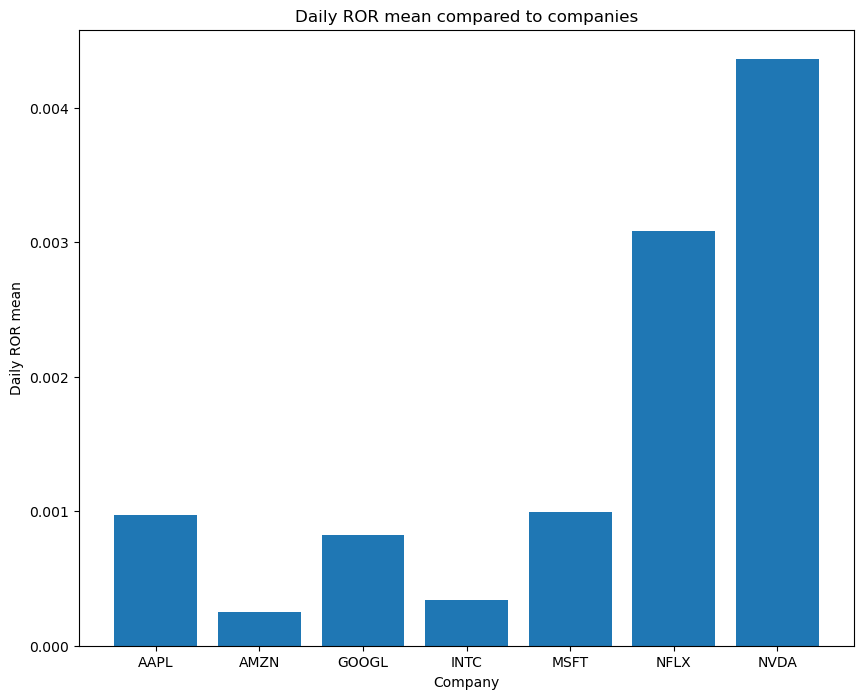

In [145]:
plt.figure(figsize=(10, 8))
plt.bar(range(len(daily_stock_return_mean)), daily_stock_return_mean)
ax = plt.subplot()
ax.set_xticks(range(len(daily_stock_return_mean)))
ax.set_xticklabels(daily_stock_return_mean.index)
plt.xlabel('Company')
plt.ylabel('Daily ROR mean')
plt.title('Daily ROR mean compared to companies')
plt.savefig('Daily_ROR_mean_compared_to_companies.png')

AAPL     0.000330
AMZN     0.000612
GOOGL    0.000492
INTC     0.000638
MSFT     0.000399
NFLX     0.000869
NVDA     0.001312
dtype: float64


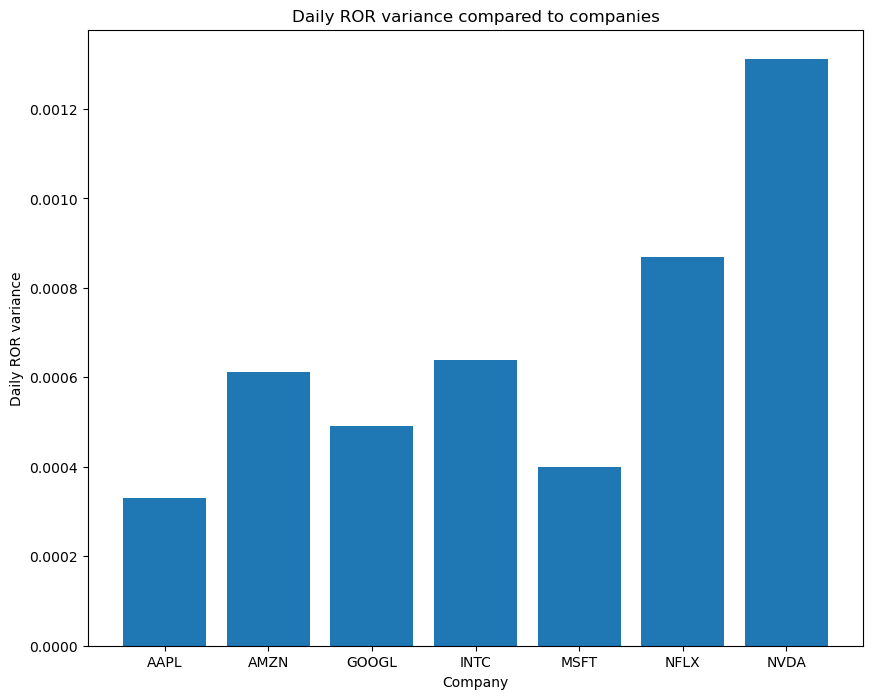

In [146]:

daily_ror_variance = daily_stock_change_pct.var()
print(daily_ror_variance)
plt.figure(figsize=(10, 8))
plt.bar(range(len(daily_ror_variance)), daily_ror_variance)
ax = plt.subplot()
ax.set_xticks(range(len(daily_ror_variance)))
ax.set_xticklabels(daily_ror_variance.index)
plt.xlabel('Company')
plt.ylabel('Daily ROR variance')
plt.title('Daily ROR variance compared to companies')
plt.savefig('Daily_ROR_variance_compared_to_companies.png')

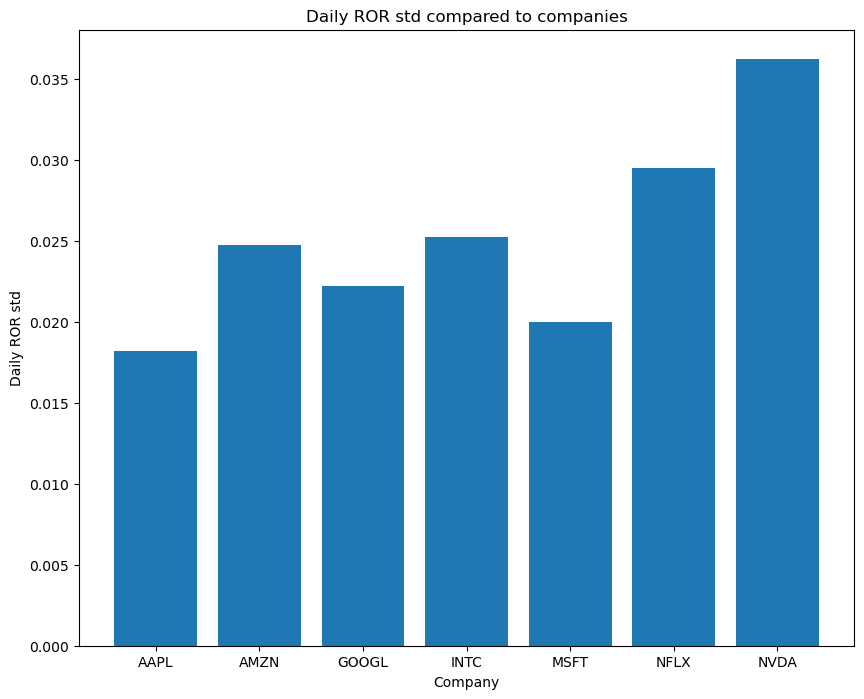

In [147]:
daily_ror_std = daily_stock_change_pct.std()

plt.figure(figsize=(10, 8))
plt.bar(range(len(daily_ror_std)), daily_ror_std)
ax = plt.subplot()
ax.set_xticks(range(len(daily_ror_std)))
ax.set_xticklabels(daily_ror_std.index)
plt.xlabel('Company')
plt.ylabel('Daily ROR std')
plt.title('Daily ROR std compared to companies')
plt.savefig('Daily_ROR_std_compared_to_companies.png')

In [148]:
correlation_daily_stock = daily_stock_change_pct.corr()
correlation_daily_stock.to_excel('correlation_table.xlsx')

In [149]:
import cvxopt as opt
from cvxopt import blas, solvers
def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df
  
  
def optimal_portfolio(returns):
    n = returns.shape[1]  # Number of assets
    returns = np.transpose(returns.values)  # Convert DataFrame to NumPy array
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]  # List of expected returns
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))  # Covariance matrix
    pbar = opt.matrix(np.mean(returns, axis=1))  # Mean returns
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # Negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))  # Matrix of zeros
    A = opt.matrix(1.0, (1, n))  # Matrix of ones
    b = opt.matrix(1.0)  # Scalar value
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]
    
    # CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]  # Portfolio returns
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]  # Portfolio risks
    
    # CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']  # Optimal portfolio weights
    
    # Convert results to NumPy arrays and return
    return np.asarray(wt), np.asarray(returns), np.asarray(risks)

In [150]:
returns_daily = stock_data['Adj Close'].pct_change()
expected_returns = returns_daily.mean()
cov_daily = returns_daily.cov()

     pcost       dcost       gap    pres   dres
 0: -1.5421e-03 -1.0043e+00  1e+00  4e-16  3e+00
 1: -1.5463e-03 -1.4326e-02  1e-02  1e-16  4e-02
 2: -1.8622e-03 -4.4219e-03  3e-03  8e-17  7e-03
 3: -3.6867e-03 -5.3184e-03  2e-03  1e-15  3e-03
 4: -4.2545e-03 -4.3076e-03  5e-05  3e-16  8e-05
 5: -4.2969e-03 -4.2975e-03  5e-07  1e-16  8e-07
 6: -4.2974e-03 -4.2974e-03  5e-09  1e-16  8e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5398e-03 -1.0043e+00  1e+00  2e-16  3e+00
 1: -1.5439e-03 -1.4322e-02  1e-02  1e-16  4e-02
 2: -1.8594e-03 -4.4169e-03  3e-03  2e-16  7e-03
 3: -3.6859e-03 -5.3117e-03  2e-03  4e-16  3e-03
 4: -4.2466e-03 -4.2996e-03  5e-05  1e-16  8e-05
 5: -4.2889e-03 -4.2895e-03  5e-07  1e-16  8e-07
 6: -4.2894e-03 -4.2894e-03  5e-09  2e-16  8e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.5371e-03 -1.0043e+00  1e+00  8e-17  3e+00
 1: -1.5412e-03 -1.4316e-02  1e-02  1e-16  4e-02
 2: -1.8563e-03 -4.4112e

 4:  5.9379e-02  5.9330e-02  5e-05  1e-16  4e-17
 5:  5.9355e-02  5.9354e-02  2e-06  1e-16  7e-17
 6:  5.9354e-02  5.9354e-02  2e-08  6e-17  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  7.9102e-02 -9.4968e-01  1e+00  3e-16  3e+00
 1:  7.8121e-02  4.1067e-02  4e-02  1e-16  1e-01
 2:  6.8655e-02  5.9907e-02  9e-03  1e-16  5e-17
 3:  6.7005e-02  6.6052e-02  1e-03  2e-16  7e-17
 4:  6.6748e-02  6.6696e-02  5e-05  1e-16  1e-16
 5:  6.6722e-02  6.6720e-02  2e-06  6e-17  6e-17
 6:  6.6721e-02  6.6721e-02  2e-08  7e-17  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.8329e-02 -9.4305e-01  1e+00  1e-17  3e+00
 1:  8.7187e-02  4.7834e-02  4e-02  7e-17  1e-01
 2:  7.6988e-02  6.7445e-02  1e-02  3e-16  5e-17
 3:  7.5275e-02  7.4280e-02  1e-03  3e-17  6e-17
 4:  7.5015e-02  7.4961e-02  5e-05  2e-16  6e-17
 5:  7.4987e-02  7.4986e-02  2e-06  1e-16  6e-17
 6:  7.4986e-02  7.4986e-02  2e-08  1e-16  3e-17
Optimal solution found.

<Figure size 1000x800 with 0 Axes>

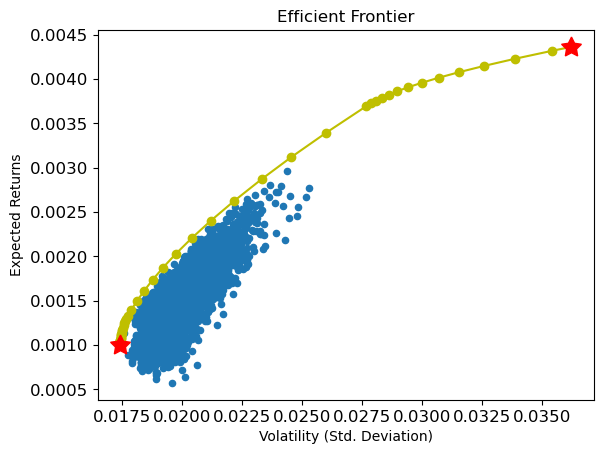

In [151]:
weights, returns, risks = optimal_portfolio(returns_daily[1:])
random_portfolios = return_portfolios(expected_returns, cov_daily) 
plt.figure(figsize=(10, 8))

min_risk_idx = np.array(risks).argmin()
max_return_idx = np.array(risks).argmax()
min_risk = [risks[min_risk_idx], returns[min_risk_idx]]
max_return = [risks[max_return_idx], returns[max_return_idx]]
random_portfolios.plot.scatter(x='Volatility', y='Returns', fontsize=12)
plt.plot(risks, returns, 'y-o')
plt.plot(min_risk[0],min_risk[1],marker=(5, 1), markersize=15, color = 'red')
plt.plot(max_return[0],max_return[1],marker=(5, 1),markersize=15, color = 'red')
plt.ylabel('Expected Returns')
plt.xlabel('Volatility (Std. Deviation)')
plt.title('Efficient Frontier')
plt.savefig('efficient_frontier.png')
plt.show()